In [64]:
# from radiant_mlhub import Dataset
# for dataset in Dataset.list():
#     print(f'{dataset.id}: {dataset.title}')

In [71]:
import shutil
import rasterio
import random
import os
import tempfile
from rasterio.plot import show
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from pytorch_lightning.loggers import CSVLogger
import torch
import xarray
import xrspatial.multispectral as ms

In [2]:
# parent project directory
PROJECT_DIR = Path.cwd().parent.resolve() / "cloud_cover_competition"

# location of the training feature and label GeoTiff files
DATA_DIR = PROJECT_DIR / "data"
print(DATA_DIR)

# folder for the training feature GeoTiffs
TRAIN_FEATURES = DATA_DIR / "train_features"
assert TRAIN_FEATURES.exists()

# folder for the training label GeoTiffs
TRAIN_LABELS = DATA_DIR / "train_labels"
assert TRAIN_LABELS.exists()

/home/ying/cloud_cover_competition/data


In [3]:
# these are the four bands that are available from the dataset
SENTINEL_BANDS = ["B02", "B03", "B04", "B08"]
RGB_BANDS = ["B02", "B03", "B04"]

In [4]:
# import the metadata CSV file
train_metadata = pd.read_csv(PROJECT_DIR / "train_metadata.csv")
train_metadata.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [5]:
# aggregate the feature chips/images by location
feature_counts_by_location = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

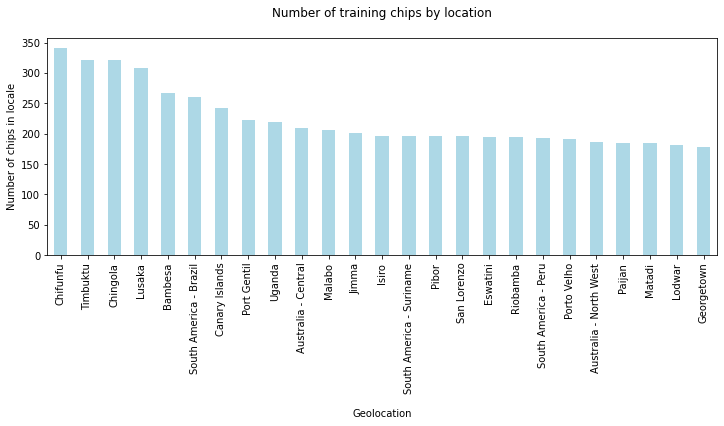

In [6]:
plt.figure(figsize=(12,4))
feature_counts_by_location.head(25).plot(kind="bar", color="lightblue")
plt.xticks(rotation=90)
plt.xlabel("\nGeolocation")
plt.ylabel("Number of chips in locale")
plt.title("Number of training chips by location\n")
plt.show()

In [7]:
def add_file_paths(df, feature_dir, label_dir=None, bands=SENTINEL_BANDS):
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()
    return df

In [8]:
train_meta = add_file_paths(train_metadata, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [9]:
def get_xarray(filepath):
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

In [10]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")
    return ms.true_color(r=red, g=green, b=blue)

In [11]:
def display_random_chip(random_state):
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    chid, location, label = random_chip.chip_id, random_chip.location, random_chip.label_path
    
    ax[0].imshow(true_color_img(chid))
    ax[0].set_title(f"Chip {chid}\n(Location: {location})")
    
    label_im = Image.open(label)
    print(np.array(label_im))
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {chid} label")
    plt.tight_layout()
    plt.show()
    
    print('-'*100)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


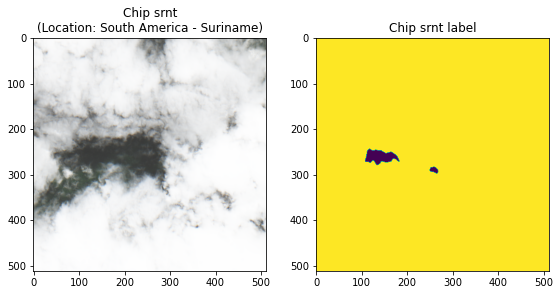

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


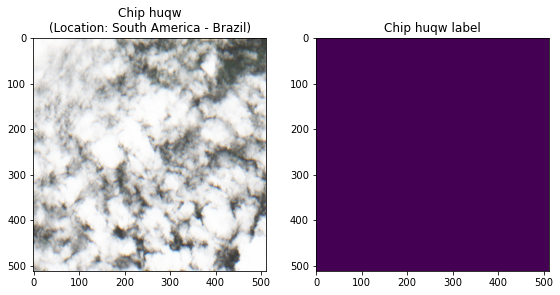

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


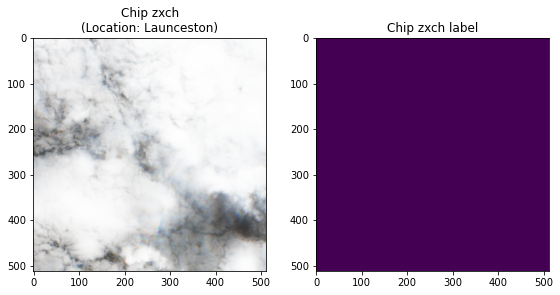

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


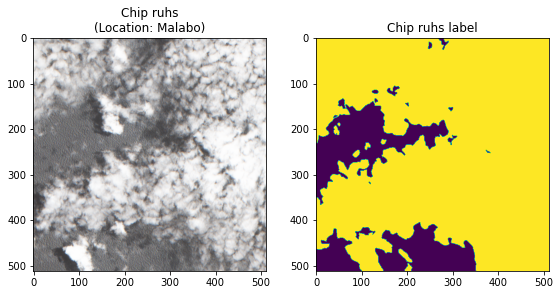

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


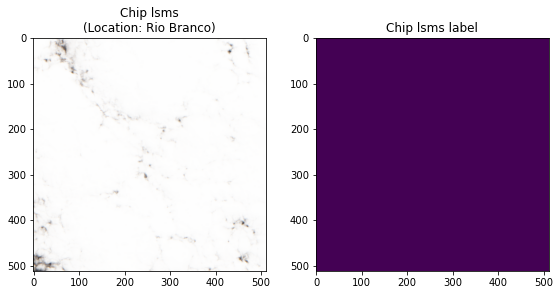

----------------------------------------------------------------------------------------------------


In [12]:
for i in range(5):
    random_index = random.randint(0, len(train_metadata))
    display_random_chip(random_index)

In [13]:
# assign column names for filepaths to each band
feature_cols = ["chip_id"] + [f"{band}_path" for band in SENTINEL_BANDS]

# feature variables
X = train_metadata[feature_cols].copy().reset_index(drop=True)

# target variable
y = train_metadata[["chip_id","label_path"]].copy().reset_index(drop=True)

In [14]:
X.head()

,chip_id,B02_path,B03_path,B04_path,B08_path
0,adwp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,adwu,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,adwz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,adxp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [15]:
y.head()

,chip_id,label_path
0,adwp,/home/ying/cloud_cover_competition/data/train_...
1,adwu,/home/ying/cloud_cover_competition/data/train_...
2,adwz,/home/ying/cloud_cover_competition/data/train_...
3,adxp,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,/home/ying/cloud_cover_competition/data/train_...


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5)

In [18]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [19]:
X_train.shape, X_test.shape, X_val.shape

((9398, 5), (1175, 5), (1175, 5))

In [20]:
y_train.shape, y_test.shape, y_val.shape

((9398, 2), (1175, 2), (1175, 2))

In [21]:
# create a folder for model output if it doesn't exist already
model_dir = Path("model_output")

if not model_dir.exists():
    model_dir.mkdir(parents=True)

In [79]:
# try:
#     from farseg_src.cloud_model import CloudFarSegModel
# except ImportError:
#     print(f"Error on import of CloudModel class")

In [44]:
# farseg_model = CloudFarSegModel(
#     bands=RGB_BANDS,
#     x_train=X_train,
#     y_train=y_train,
#     x_val=X_val,
#     y_val=y_val
# )

In [75]:
# lightning_trainer = pl.Trainer(
#     gpus=1,
#     fast_dev_run=True, # this parameter does a dev run to see if model will train
#     callbacks=[checkpoint_callback, early_stopping_callback],
#     logger=csv_logger,
#     log_every_n_steps=50
# )

In [131]:
from torchgeo.trainers import SemanticSegmentationTask

In [132]:
from cloud import Sentinel2CloudCoverDataModule

In [133]:
semseg_task = SemanticSegmentationTask(
    segmentation_model="deeplabv3+", 
    encoder_name="resnet50", 
    encoder_weights="imagenet", 
    in_channels=4, 
    num_classes=2, 
    loss="jaccard",
    ignore_zeros=False
)

In [134]:
cloud_module = Sentinel2CloudCoverDataModule(
    root_dir=DATA_DIR,
    seed=42,
    batch_size=4,
    num_workers=6,
    x_paths=X,
    y_paths=y
)

In [135]:
experiment_dir = os.path.join(tempfile.gettempdir(), "cloud_results")

In [136]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=experiment_dir,
    monitor="iou_epoch",
    mode="max", 
    verbose=True
)

In [137]:
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(farseg_model.patience),
    mode="max",
    verbose=True,
)

In [138]:
csv_logger = CSVLogger(
    save_dir=experiment_dir,
    name="training_logs"
)

In [139]:
lightning_trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[csv_logger],
    default_root_dir=experiment_dir,
    min_epochs=1,
    max_epochs=10,
    fast_dev_run=True
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).


In [140]:
torch.cuda.is_available()

True

In [130]:
torch.cuda.empty_cache()

In [141]:
lightning_trainer.fit(model=semseg_task, datamodule=cloud_module)

TypeError: __init__() got an unexpected keyword argument 'checksum'

In [51]:
# lightning_trainer.fit(model=farseg_model)

In [52]:
# model_weight_path = model_dir / "cloud_model.pt"
# torch.save(farseg_model.state_dict(), model_weight_path)

In [ ]:
# checkpoint_file = '/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=14-step=14759.ckpt'

In [ ]:
# checkpoint = torch.load(checkpoint_file)

In [ ]:
# cloud_model.load_state_dict(checkpoint['state_dict'])